# A Neural Algorithm of Artistic Style

### Import

In [1]:
import vgg

import tensorflow as tf
import numpy as np

from PIL import Image

from functools import reduce

import scipy.misc


from sys import stderr
from IPython import display

from IPython.core.debugger import Tracer

### VGG

- **load_net(data_path)**
    - description
        - vgg19 network load from data_path
    - return
        - weights : vgg matrix
        - mean_pixel : avg pixels (3 channels)
    
        

- **net_preloaded(weights, input_image, pooling)**
    - parameters
        - weights : vgg matrix
        - input_image : input_image
        - pooling : string (max or avg)
    - description
        - Image가 weight 각각의 conv, relu, pool layer를 통과했을때의 결과를 net 에 저장한다.
    - return 
        - net
    
    
- **preprocess(image, mean_pixel)**
    - parameters
        - image : input_image with shape (height, width, color)
        - mean_pixels : vgg_mean_pixel with shape (color)
    - description
        - image[height][width] - mean_pixel 을 return한다.
        - normalize
    - return
        - image - mean_pixel
        
        
- **unprocess(image, mean_pixel)**
    - parameters
        - image : input_image with shape (height, width, color)
        - mean_pixels : vgg_mean_pixel with shape (color)
    - description
        - image[height][width] + mean_pixel 을 return한다.
        - restore
    - return
        - image + mean_pixel

### Constants

In [2]:
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

content_weight = 5e0
content_weight_blend = 1
style_weight = 5e2
tv_weight = 1e2
style_layer_weight_exp = 1
learning_rate = 1e1
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-08
style_scale = 1.0
iterations = 1000
print_iterations = None
checkpoint_iterations = 100
preserve_colors = False

network = 'imagenet-vgg-verydeep-19.mat'
pooling = 'max'

### Image functions

In [3]:
def imread(path):
    img = scipy.misc.imread(path).astype(np.float)
    # grayscale
    if len(img.shape) == 2:
        img = np.dstack((img,img,img))
        
    # PNG with alpha channel
    elif img.shape[2] == 4:
        img = img[:,:,:3]
    return img


def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    Image.fromarray(img).save(path, quality=95)
    

### Helper functions

- **_tensor_size(tensor)**
    - description
        - size = height * width * color
    - return
        - size


- **rgb2gray(rgb)**
    - parameters
        - rgb : rgb image widht shape (height, width, 3)
    - description
        - [0.299, 0.587, 0.114]를 곱해서 (height, width, 1) 의 grayscale로 바꾼다.
    - return 
        - gray image : grayscaled image with shape (height, width, 1)


- **gray2rgb(gray)**
    - parameters
        - gray : grayscaled image with shape (height, width, 1)
    - description
        - Image의 shape을 (height, width, 3)으로 바꾼다.
        - 값을 복사하기 때문에 rgb값을 복원하는 것은 아니다.
    - return
        - 3 channel image : grayscaled image with shape (height, width, 3)

In [4]:
def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def gray2rgb(gray):
    w, h = gray.shape
    rgb = np.empty((w, h, 3), dtype=np.float32)
    rgb[:, :, 2] = rgb[:, :, 1] = rgb[:, :, 0] = gray
    return rgb

### Load content/style Images

In [5]:
content_name = 'cat2'
style_name = 'style7'

# style 1, 2 jpg
# style 3~7 png

content_source = 'samples/content/' + content_name + '.png'
style_sources = ['samples/style/' + style_name + '.png'] # , 'samples/style/style3.png']
output = 'samples/output/' + content_name + '-' + style_name + '-out.jpg'
checkpoint_output = 'samples/checkpoints/' + content_name + '-' + style_name + '-%s.jpg'

content = imread(content_source)
styles = [imread(style) for style in style_sources]

target_shape = content.shape
for i in range(len(styles)):
    # Resize style images
    styles[i] = scipy.misc.imresize(styles[i], style_scale * target_shape[1] / styles[i].shape[1])

style_blend_weights = [1.0/len(styles) for _ in styles]

### Image samples

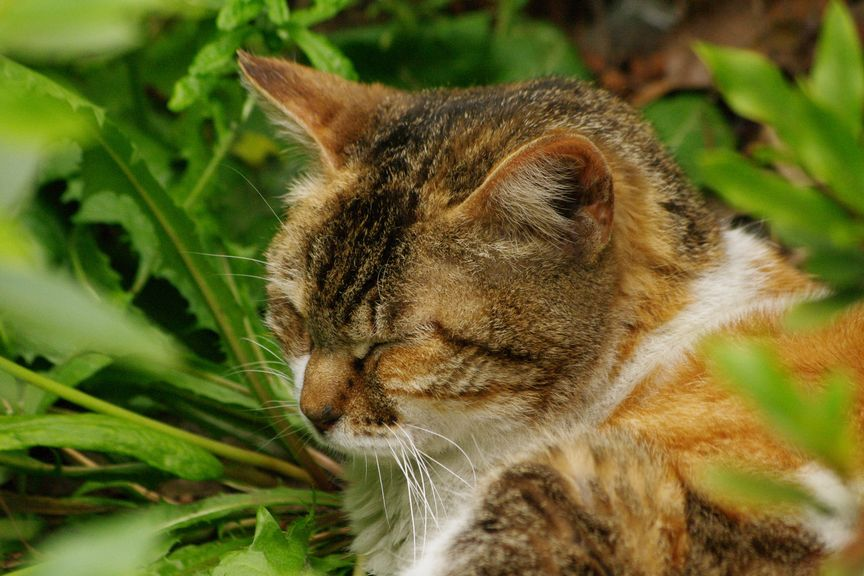

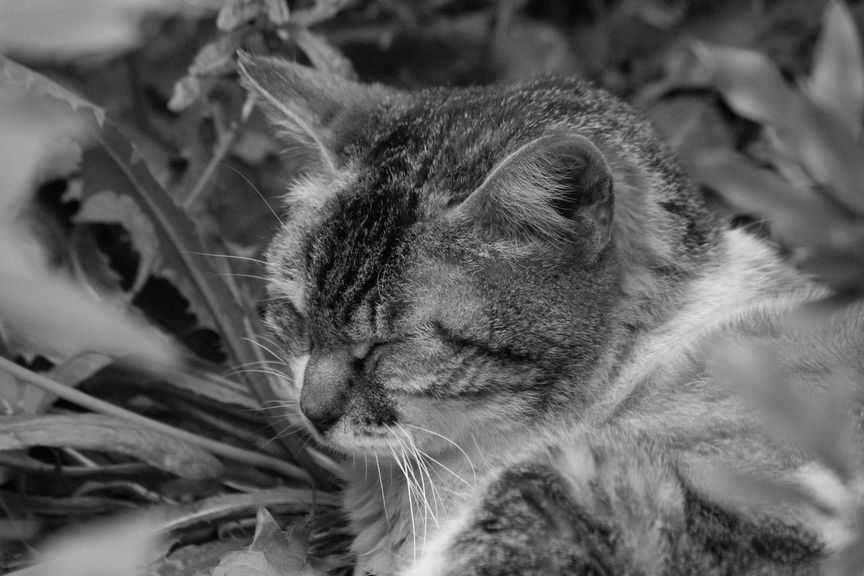

In [7]:
display.display(display.Image(content_source))

gray = rgb2gray(content)
imsave('gray.jpg', gray)
display.display(display.Image('gray.jpg'))

# display.display(display.Image(style_sources[0]))

### Initialize Network

In [8]:
shape = (1,) + content.shape
style_shapes = [(1,) + style.shape for style in styles]
content_features = {}
style_features = [{} for _ in styles]

vgg_weights, vgg_mean_pixel = vgg.load_net(network)

layer_weight = 1.0
style_layers_weights = {}
for style_layer in STYLE_LAYERS:
    style_layers_weights[style_layer] = layer_weight
    layer_weight *= style_layer_weight_exp
    
# normalize style layer weights
layer_weights_sum = 0
for style_layer in STYLE_LAYERS:
    layer_weights_sum += style_layers_weights[style_layer]
for style_layer in STYLE_LAYERS:
    style_layers_weights[style_layer] /= layer_weights_sum

### Feedforward

In [9]:
# compute content features in feedforward mode
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)
    net = vgg.net_preloaded(vgg_weights, image, pooling)
    content_pre = np.array([vgg.preprocess(content, vgg_mean_pixel)])
    for layer in CONTENT_LAYERS:
        content_features[layer] = net[layer].eval(feed_dict={image: content_pre})

# compute style features in feedforward mode
for i in range(len(styles)):
    with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
        image = tf.placeholder('float', shape=style_shapes[i])
        net = vgg.net_preloaded(vgg_weights, image, pooling)
        style_pre = np.array([vgg.preprocess(styles[i], vgg_mean_pixel)])
        for layer in STYLE_LAYERS:
            features = net[layer].eval(feed_dict={image: style_pre})
            features = np.reshape(features, (-1, features.shape[3]))
            
            # features to gram matrix
            gram = np.matmul(features.T, features) / features.size
#             gram = np.matmul(features.T, features)
            style_features[i][layer] = gram

### Backpropagation to generate stylized image

In [10]:
with g.as_default():
    # Initial Image from random noise
    noise = np.random.normal(size = shape, scale = np.std(content) * 0.1)
    initial = tf.random_normal(shape) * 0.256

    image = tf.Variable(initial)
    net = vgg.net_preloaded(vgg_weights, image, pooling)
    
    print(net)
    print(net['relu1_1'].get_shape())
    
    # content loss
    content_layers_weights = {}
    content_layers_weights[CONTENT_LAYERS[0]] = content_weight_blend
    content_layers_weights[CONTENT_LAYERS[1]] = 1.0 - content_weight_blend
    
    content_loss = 0
    content_losses = []
    for content_layer in CONTENT_LAYERS:
        content_losses.append(content_layers_weights[content_layer] * content_weight # alpha (ratio)
                             * (2 * tf.nn.l2_loss(net[content_layer] - content_features[content_layer])
                             / content_features[content_layer].size))
        
#         content_losses.append(content_layers_weights[content_layer] * content_weight # alpha (ratio)
#                               * tf.nn.l2_loss(net[content_layer] - content_features[content_layer]))
    content_loss += reduce(tf.add, content_losses)
    
    # style loss
    style_loss = 0
    for i in range(len(styles)):
        style_losses = []
        for style_layer in STYLE_LAYERS:
            layer = net[style_layer]
            _, height, width, number = map(lambda i: i.value, layer.get_shape())
            size = height * width * number
            feats = tf.reshape(layer, (-1, number))
            gram = tf.matmul(tf.transpose(feats), feats) / size
#             gram = tf.matmul(tf.transpose(feats), feats)
            style_gram = style_features[i][style_layer]
            # style_losses.append(style_layers_weights[style_layer] * 2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
            style_losses.append(style_layers_weights[style_layer] * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
#             style_losses.append(style_layers_weights[style_layer] / 2 * tf.nn.l2_loss(gram - style_gram) / size / size)
        style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses) # beta (ratio)

    # total variation denoising
    
    
    tv_y_size = _tensor_size(image[:,1:,:,:])
    tv_x_size = _tensor_size(image[:,:,1:,:])

#     tv_loss = tv_weight * 2 * (
#             (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
#                 tv_y_size) +
#             (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
#                 tv_x_size))

    tv_beta = 2
   
    tv_loss = tv_weight * 2 * (
        tf.pow(
            (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
                tv_y_size) +
            (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
                tv_x_size)
            , tv_beta/2)
    )

    # tv_loss = tv_weight * 2 * tf.reduce_sum(tf.image.total_variation(image))
    # overall loss
    loss = content_loss + style_loss + tv_loss

    # optimizer setup
    train_step = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon).minimize(loss)

    def print_progress():
        stderr.write('  content loss: %g\n' % content_loss.eval())
        stderr.write('    style loss: %g\n' % style_loss.eval())
        stderr.write('       tv loss: %g\n' % tv_loss.eval())
        stderr.write('    total loss: %g\n' % loss.eval())

    # optimization
    best_loss = float('inf')
    best = None
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        stderr.write('Optimization started...\n')
        if (print_iterations and print_iterations != 0):
            print_progress()
        for i in range(iterations):
            # stderr.write('Iteration %4d/%4d\n' % (i + 1, iterations))
            train_step.run()

            last_step = (i == iterations - 1)
            if last_step or (print_iterations and i % print_iterations == 0):
                print_progress()

            if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
                this_loss = loss.eval()
                if this_loss < best_loss:
                    best_loss = this_loss
                    best = image.eval()

                img_out = vgg.unprocess(best.reshape(shape[1:]), vgg_mean_pixel)
                    
                if last_step:
                    imsave(output, img_out)
                    display.display(display.Image(output))
                    
                elif i%checkpoint_iterations == 0:
                    stderr.write('Iteration %4d/%4d\n' % (i + 1, iterations))
                    imsave(checkpoint_output%i, img_out)
                    print_progress()
                    display.display(display.Image(checkpoint_output%i))



{'conv4_3': <tf.Tensor 'BiasAdd_42:0' shape=(1, 72, 108, 512) dtype=float32>, 'relu5_2': <tf.Tensor 'Relu_45:0' shape=(1, 36, 54, 512) dtype=float32>, 'relu4_3': <tf.Tensor 'Relu_42:0' shape=(1, 72, 108, 512) dtype=float32>, 'relu4_4': <tf.Tensor 'Relu_43:0' shape=(1, 72, 108, 512) dtype=float32>, 'conv5_1': <tf.Tensor 'BiasAdd_44:0' shape=(1, 36, 54, 512) dtype=float32>, 'relu3_1': <tf.Tensor 'Relu_36:0' shape=(1, 144, 216, 256) dtype=float32>, 'relu4_1': <tf.Tensor 'Relu_40:0' shape=(1, 72, 108, 512) dtype=float32>, 'relu2_2': <tf.Tensor 'Relu_35:0' shape=(1, 288, 432, 128) dtype=float32>, 'pool3': <tf.Tensor 'MaxPool_10:0' shape=(1, 72, 108, 256) dtype=float32>, 'relu5_4': <tf.Tensor 'Relu_47:0' shape=(1, 36, 54, 512) dtype=float32>, 'pool2': <tf.Tensor 'MaxPool_9:0' shape=(1, 144, 216, 128) dtype=float32>, 'conv5_3': <tf.Tensor 'BiasAdd_46:0' shape=(1, 36, 54, 512) dtype=float32>, 'relu1_2': <tf.Tensor 'Relu_33:0' shape=(1, 576, 864, 64) dtype=float32>, 'relu4_2': <tf.Tensor 'Relu_

Optimization started...


ResourceExhaustedError: OOM when allocating tensor with shape[1,576,864,64]
	 [[Node: Conv2D_32 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable/read, Const_32)]]

Caused by op 'Conv2D_32', defined at:
  File "/home/yujinee/.pyenv/versions/3.5.2/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/yujinee/.pyenv/versions/3.5.2/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-c1e18f2bba69>", line 7, in <module>
    net = vgg.net_preloaded(vgg_weights, image, pooling)
  File "/home/yujinee/deploy/test/Tensorflow/artistic/vgg.py", line 42, in net_preloaded
    current = _conv_layer(current, kernels, bias)
  File "/home/yujinee/deploy/test/Tensorflow/artistic/vgg.py", line 54, in _conv_layer
    padding='SAME')
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/yujinee/.pyenv/versions/basic_searcher/envs/artistic/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,576,864,64]
	 [[Node: Conv2D_32 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable/read, Const_32)]]
